<a href="https://colab.research.google.com/github/gmagannaDevelop/segnet/blob/mru_tests/Comparative_MultiResUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MultiResUNet
## DCI-Net
#### Gustavo Magaña

\########################################################

In [0]:
!ls

sample_data


In [0]:
!apt install jq

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libjq1 libonig4
The following NEW packages will be installed:
  jq libjq1 libonig4
0 upgraded, 3 newly installed, 0 to remove and 7 not upgraded.
Need to get 276 kB of archives.
After this operation, 930 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libonig4 amd64 6.7.0-1 [119 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libjq1 amd64 1.5+dfsg-2 [111 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 jq amd64 1.5+dfsg-2 [45.6 kB]
Fetched 276 kB in 0s (2,911 kB/s)
Selecting previously unselected package libonig4:amd64.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../lib

In [0]:
## If changes are made to the repo, uninstall and
## a fresh pip install are required, so it seems.
#!pip uninstall segnet
!pip install git+https://github.com/gmagannaDevelop/segnet.git@mru_tests
##!pip install git+https://github.com/gmagannaDevelop/segnet.git@log_hotfix

  Cloning https://github.com/gmagannaDevelop/segnet.git (to revision mru_tests) to /tmp/pip-req-build-o0o7secf
  Running command git clone -q https://github.com/gmagannaDevelop/segnet.git /tmp/pip-req-build-o0o7secf
  Running command git checkout -b mru_tests --track origin/mru_tests
  Switched to a new branch 'mru_tests'
  Branch 'mru_tests' set up to track remote branch 'mru_tests' from 'origin'.
     |████████████████████████████████| 215kB 11.9MB/s 
     |████████████████████████████████| 102kB 9.2MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 307kB 18.1MB/s 
     |████████████████████████████████| 737kB 25.3MB/s 
  Created wheel for segnet: filename=segnet-0.4-cp36-none-any.whl size=24435 sha256=81d2781975c017c52bde1bce9d9fcbee26819674c2e8c94cf9c29fa1d65c46fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-m6io7o2k/wheels/f1/c1/51/0ee27f445c3a618413714a84d4f5500547456389437

Imports

In [0]:
### System-related
import sys
import os
import datetime 
from typing import Optional
#import importlib.util
###############################################################

### Machine learning specific
#import segmentation_models as sm
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import keras.models
###############################################################

### In-Out
from skimage import io
import glob
###############################################################

### Visualization
import seaborn as sns
###############################################################

### Numerical
import numpy as np
###############################################################

### Repo-specific (segnet)
from segnet.train import train_segnet
from segnet.models import multiresunet as mru
from segnet.models import multiresunet2 as mru2
from segnet.models import multiresunet3 as mru3
from segnet.utils import timing
#from segnet.segnet.train.train_segnet import train_segnet
#import segnet.segnet as segnet

### Data-related
from google.colab import drive, files
drive.mount('/content/drive/')
###############################################################


### Not an import, but mandatory to be defined here :
root_dir   = "drive/My Drive/DCI-Net"
_log_file  = os.path.join(root_dir, "time_logs.jsonl")

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Function definition

In [0]:
def yield_model_name(
    architecture: str = "MultiResUNet",
    _name: Optional[str] = None,
    date: Optional[str] = None
) -> str:
  """
    Yield a model name, to be passed to other functions.
    Said model name consisting of an architecture name, 
    the (UTCtime)
  """
  if date is None:
    date = str(datetime.datetime.utcnow()).split(".")[0]
  if _name is not None:
    return f"{architecture}-({_name})-({date}).h5"

  return f"{architecture}-({date}).h5"

def yield_mask_directory(
    architecture: str = "MultiResUNet",
    date: Optional[str] = None
) -> str:
  """
    Yield a model name, to be passed to other functions.
    Said model name consisting of an architecture name, 
    the (UTCtime)
  """
  if date is None:
    date = str(datetime.datetime.utcnow()).split(".")[0]
    #date = str(datetime.datetime.utcnow()).split(".")[0].split(" ")[0]
  return f"{architecture}-({date})"

In [0]:
yield_model_name(_name='lol')

'MultiResUNet-(lol)-(2020-01-12 01:30:45).h5'

In [0]:
yield_mask_directory()

'MultiResUNet-(2020-01-12 01:30:47)'

In [0]:
!ls "drive/My Drive/DCI-Net/Masks"

Sunday3nov


In [0]:
!ls "drive/My Drive/DCI-Net/Colab_data/Dataset 2"

imgs  msks


In [0]:
# Declare the paths to use (following the Keras convention)
# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#fit_generator

# Original datasets : COLONOSCOPY
# masks_path = img_path = data_path  = "drive/My Drive/DCI-Net/Colab_data/colonoscopy"

# Original datasets : DERMOSCOPY
 masks_path = img_path = data_path  = "drive/My Drive/DCI-Net/Colab_data/dermoscopy80"

# Chinese dataset (Abdiel's) :
#masks_path = img_path = data_path  = "drive/My Drive/DCI-Net/Colab_data/Dataset 2"

_img_path   = os.path.join(data_path, 'imgs')
_masks_path = os.path.join(data_path, 'msks')


_model_snapshots_dir = os.path.join(root_dir, "ModelSnapshots")
_model_log_path = os.path.join(
    _model_snapshots_dir, 
    yield_model_name(architecture="MultiResUNet")
)


In [0]:
_model_authors = list(
    map(
        lambda x: os.path.join(_model_snapshots_dir, yield_model_name(_name=x)), ['Edwin', 'Gustavo', 'Original'] 
        )
    )
_model_authors

['drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Edwin)-(2020-01-12 02:46:40).h5',
 'drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Gustavo)-(2020-01-12 02:46:40).h5',
 'drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Original)-(2020-01-12 02:46:40).h5']

In [0]:
print(f"{data_path}\n {masks_path}\n {img_path}\n {_img_path}\n {_masks_path}\n {_model_log_path}")

drive/My Drive/DCI-Net/Colab_data/dermoscopy80
 drive/My Drive/DCI-Net/Colab_data/dermoscopy80
 drive/My Drive/DCI-Net/Colab_data/dermoscopy80
 drive/My Drive/DCI-Net/Colab_data/dermoscopy80/imgs
 drive/My Drive/DCI-Net/Colab_data/dermoscopy80/msks
 drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(2020-01-12 02:46:37).h5


Define hyperparameters


In [0]:
__comments = (lambda x: [
              f"Edwin's implementation : models/multiresunet.py, Dataset : {x}",
              f"Gustavo's implementation : models/multiresunet2.py, Dataset : {x}",
              f"Original implementation : models/multiresunet3.py, Dataset : {x}", 
])("Dermoscopy 80 images")

hyper_params = dict(
    batch_size = 4,
    epochs = 40,
    steps_per_epoch=5
    #model_file = _model_log_path
)

# DEBUG COMMENT OUT WHEN TRAINING : 
_debug_hyper_params = dict(
    batch_size = 8,
    epochs = 1,
    steps_per_epoch=2,
    model_file = _model_log_path
)

Get the stored snapshots :

In [0]:
snapshots = os.listdir(_model_snapshots_dir)
snapshots

['MultiResUNet-(2019-10-29 03:29:04).h5',
 'MultiResUNet-(2019-11-04 01:48:44).h5',
 'MultiResUNet-(2019-11-04 03:14:17).h5',
 'MultiResUNet-(2019-11-04 03:30:53).h5',
 'MultiResUNet-(2019-11-04 19:16:27).h5',
 'MultiResUNet-(Edwin)-(2019-11-04 21:36:35).h5',
 'MultiResUNet-(Gustavo)-(2019-11-04 21:36:35).h5',
 'MultiResUNet-(Original)-(2019-11-04 21:36:35).h5',
 'MultiResUNet-(Edwin)-(2020-01-11 23:55:36).h5',
 'MultiResUNet-(Gustavo)-(2020-01-11 23:55:36).h5',
 'MultiResUNet-(Original)-(2020-01-11 23:55:36).h5',
 'MultiResUNet-(2020-01-11 23:41:29).h5']

Choose a snapshot to load, if so desired :

In [0]:
load_snapshot = os.path.join(_model_snapshots_dir, snapshots[0])
load_snapshot

'drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(2019-10-29 03:29:04).h5'


Instantiate a MultiResUNet model, **optionally** from a checkpoint :

In [0]:
models = [
  mru.MultiResUnet(),
  mru2.MultiResUNet(),
  mru3.MultiResUnet()
]
    
# TOGGLE THIS !
from_checkpoint = False

if from_checkpoint:
  # model1.load_weights(load_snapshot)
  # model2.load_weights(load_snapshot)
  pass

In [0]:
trainer = lambda x, y, z: train_segnet.train_segnet(
    x,
    _img_path,
    _masks_path,
    **hyper_params,
    model_file=y,
    _comment=z
)

In [0]:
#os.listdir(os.path.join(_img_path, 'images''))

In [0]:
#import PIL
#from PIL import Image as pilim

In [0]:
#PIL.__version__

In [0]:
#x = pilim.open(os.path.join(_img_path, 'images/527 (1).tif'))

In [0]:
historiae = list(map(trainer, models, _model_authors, __comments))

Found 64 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 16 images belonging to 1 classes.
Found 16 images belonging to 1 classes.
Epoch 1/40
5/5 [==============================] - 14s 3s/step - loss: 0.5760 - jaccard_index: 0.1832 - dice_coef: 0.3092

Epoch 00001: val_jaccard_index improved from -inf to 0.18324, saving model to drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Edwin)-(2020-01-12 02:46:40).h5
5/5 [==============================] - 154s 31s/step - loss: 0.6377 - jaccard_index: 0.3142 - dice_coef: 0.4739 - val_loss: 0.5760 - val_jaccard_index: 0.1832 - val_dice_coef: 0.3092
Epoch 2/40
5/5 [==============================] - 0s 87ms/step - loss: 0.5767 - jaccard_index: 0.1935 - dice_coef: 0.3235

Epoch 00002: val_jaccard_index improved from 0.18324 to 0.19349, saving model to drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Edwin)-(2020-01-12 02:46:40).h5
5/5 [==============================] - 3s 520ms/step - loss: 0.4683 - jaccard_index: 

Train the model :

In [0]:
"""
history = train_segnet.train_segnet(
    models[2],
    _img_path,
    _masks_path,
    **hyper_params,
    _comment=__comments[2]
)
"""


'\nhistory = train_segnet.train_segnet(\n    models[2],\n    _img_path,\n    _masks_path,\n    **hyper_params,\n    _comment=__comments[2]\n)\n'

In [0]:
print(_masks_path)

drive/My Drive/DCI-Net/Colab_data/dermoscopy80/msks


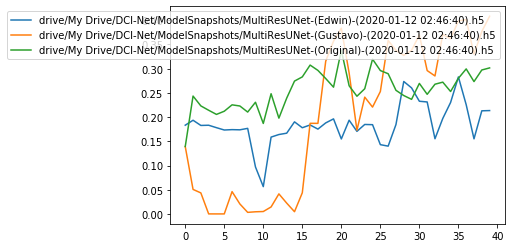

In [0]:
_jaccards = list(map(lambda x: x.history['val_jaccard_index'], historiae))
for _jaccard, _author in zip(_jaccards, _model_authors):
  sns.lineplot(list(range(len(_jaccard))), _jaccard, label=_author)

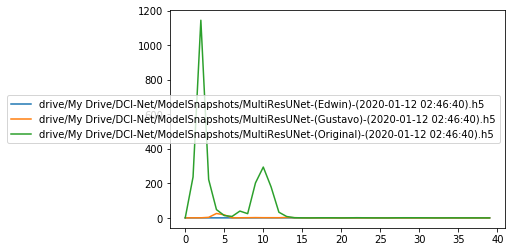

In [0]:
_losses = list(map(lambda x: x.history['val_loss'], historiae))
for _loss, _author in zip(_losses, _model_authors):
  sns.lineplot(list(range(len(_loss))), _loss, label=_author)

In [0]:
!cat "drive/My Drive/DCI-Net/time_logs.jsonl" | jq

/bin/bash: jq: command not found
cat: 'drive/My Drive/DCI-Net/time_logs.jsonl': No such file or directory


In [0]:
# 1 validación 5 pliegues
def 

In [0]:
@timing.time_log(path_to_logfile=_log_file)
def _dummy_debug_function(*args, **kw):
  pass
  

In [0]:
log

NameError: ignored

In [0]:
_dummy_debug_function(5, '234', 5.2, hola='pass', foo='bar')